In [34]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nbimporter
import mainstream_tests

from matplotlib import rc
rc('text', usetex=True)

In [28]:
def get_songs_data(cleaned_data, recommended=True, obs_threshold=7, separate_rec=True):
    """
    Gets the number of songs and plays for each user (calculates S/P diversity index)
    :param obs_threshold: user must have this number of observations of more to be kept in the dataset
    :param cleaned_data: data after removing outliers
    :param recommended: gets the recommended part of the dataset if True, the organic part otherwise
    :return: a pandas Series with [user_id, S/P] as its rows
    """
    if separate_rec:
        # Separating based on entry's origin -- should use map function if refactoring ever occurs
        if recommended:
            songs_data = cleaned_data[cleaned_data["origin"].str.contains("flow|reco")]
        else:
            songs_data = cleaned_data[~cleaned_data["origin"].str.contains("flow|reco")]
    else:
        songs_data = cleaned_data
    
    # Computing for each user every S and their respective P
    songs_data = songs_data.groupby(["user_id", "sng_id"]).size()

    # Determine and drop cases with too few observations (see obs_threshold)
    thresh_tester = songs_data.sum(level="user_id")
    thresh_tester = thresh_tester[thresh_tester < obs_threshold]
    songs_data.drop(thresh_tester.index.values, inplace=True)

    # No exception will be raised even on empty series (in case no value is above obs-threshold)
    songs_data = songs_data.groupby(["user_id"]).size().divide(songs_data.sum(level="user_id"))
    return songs_data

In [3]:
FILE_NAME = "../../data/artist_streams.csv"

MIN_REC = 17
MIN_ORG = 83

print("Reading data...")
data = pd.read_csv(FILE_NAME)
data

Reading data...


,user_id,ts,sng_id,album_id,listening_time,listen_type,origin,art_id
0,53a2a460127df49eef5976193c14728c695c3463,1471344689,121710324,12721422,203,MOD,page_playlist,249599
1,d81f8a1d9fd30af3c189fbe99c26fd6d4db11375,1471364400,121710324,12721422,1,MOD,page_playlist,249599
2,b26ce863e9161cc7e36cdf254927457cc5ceb55b,1471320765,121710324,12721422,203,MOD,page_playlist,249599
3,206929899c1bfc3c49174d20824ab1dc77758567,1471355821,121710324,12721422,115,smartradio,flow,249599
4,111f74340b5ef733f7dc99dc5494de3da4dbeea7,1471336531,121710324,12721422,203,smartradio,flow,249599
...,...,...,...,...,...,...,...,...
2242112,bb2a3a806a8d9ae05bc63fa2182a3fb645530a49,1471505913,117303310,12174146,14,MOD,page_album,1197905
2242113,92ff662b58d3bd81e5cdc06a6438ad4bf490d938,1471983156,9900601,907173,18,MOD,page_album,1182806
2242114,92ff662b58d3bd81e5cdc06a6438ad4bf490d938,1471982447,9900591,907173,9,MOD,page_album,1182806
2242115,92ff662b58d3bd81e5cdc06a6438ad4bf490d938,1471982430,9900589,907173,8,MOD,page_album,1182806


In [4]:
data = mainstream_tests.clean_data(data)
data

Computing z-score...
Cleaning...


,user_id,ts,sng_id,album_id,listening_time,listen_type,origin,art_id
0,53a2a460127df49eef5976193c14728c695c3463,1471344689,121710324,12721422,203,MOD,page_playlist,249599
2,b26ce863e9161cc7e36cdf254927457cc5ceb55b,1471320765,121710324,12721422,203,MOD,page_playlist,249599
3,206929899c1bfc3c49174d20824ab1dc77758567,1471355821,121710324,12721422,115,smartradio,flow,249599
4,111f74340b5ef733f7dc99dc5494de3da4dbeea7,1471336531,121710324,12721422,203,smartradio,flow,249599
5,5f935bea161673f83b0645325bc3da5d113b7f91,1471353443,121710324,12721422,203,MOD,page_playlist,249599
...,...,...,...,...,...,...,...,...
2242099,b3007b94f1a0eb95c508d4fea8320b862ce29a7b,1473194917,93916044,9543328,44,MOD,page_album,308253
2242104,2ad14bc4eb38a15310b0b00b87494a67ed47100d,1475437996,113798794,11786202,73,MOD,page_artist,4312845
2242106,2130c0788bffdf1acc303448c710cee67fc1a629,1476980760,75644372,7492179,84,MOD,page_album,417037
2242110,a351ff8a54dcb58cfa06de787d010220a9565fa2,1471467359,13157903,1207138,44,MOD,page_artist,2380


In [5]:
data.groupby("user_id").size()

user_id
00877d231a1d10859eefd4288ecc493fd1ea3589    4152
018ca9ed6e4c4a466ff2ac0cccc00b0733e8976e    2502
01d78f7619786f5f06843b5f1cb7d7b15a934731    1293
0282983996af7f6b2a27cfff67fc8982619561d6    1763
02eae2623eaf23461bbadd9c4f3ae1f659a90809    1149
                                            ... 
fe22a3978a595c3a63cb40558db7804956f8e1d7     448
fe8b03dc9d448192808c8cd2bf76657b7562b3ae     743
fea927761d221701b2bf1b6acc2de6d91d060071    2812
ff7672529f1387bf35e1296f79009275287980a8    1648
ff82befb6c2bcf11c638706bc27cf787128426de     402
Length: 1022, dtype: int64

## Po/Pr

In [6]:
data["reco"] = data["origin"].map(mainstream_tests.is_reco)
rec_org_plays = data.groupby(["user_id", "reco"]).size().to_frame().reset_index()
rec_org_plays = rec_org_plays[rec_org_plays["reco"] == False].merge(rec_org_plays[rec_org_plays["reco"] == True], on="user_id").drop(["reco_x", "reco_y"], axis=1)
rec_org_plays.columns = ["user_id", "Po", "Pr"]
rec_org_plays

<ipython-input-6-89b9e03d6267>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["reco"] = data["origin"].map(mainstream_tests.is_reco)


,user_id,Po,Pr
0,00877d231a1d10859eefd4288ecc493fd1ea3589,2256,1896
1,018ca9ed6e4c4a466ff2ac0cccc00b0733e8976e,2052,450
2,01d78f7619786f5f06843b5f1cb7d7b15a934731,1288,5
3,0282983996af7f6b2a27cfff67fc8982619561d6,1454,309
4,02eae2623eaf23461bbadd9c4f3ae1f659a90809,1016,133
...,...,...,...
939,fe016f7c946213bd53ca9b683b7314d24d2dbba9,618,36
940,fe22a3978a595c3a63cb40558db7804956f8e1d7,440,8
941,fe8b03dc9d448192808c8cd2bf76657b7562b3ae,738,5
942,fea927761d221701b2bf1b6acc2de6d91d060071,2800,12


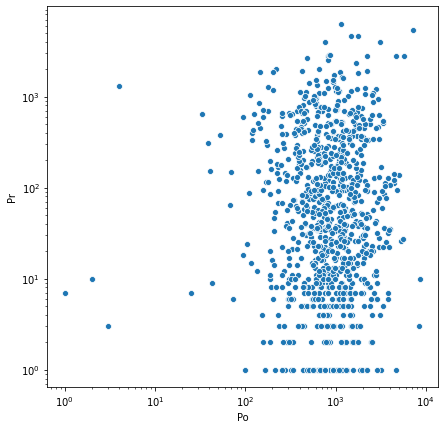

In [7]:
f, ax = plt.subplots(figsize=(7, 7))
ax.set(xscale="log", yscale="log")
sns.scatterplot(x="Po", y="Pr", data=rec_org_plays)
plt.savefig("../../results/plays_rec_org_loglog.pdf")

## So/Po vs Sr/Pr

In [8]:
print("Computing diversity ratio...")
rec_data = get_songs_data(data, recommended=True, obs_threshold=0)
org_data = get_songs_data(data, recommended=False, obs_threshold=0)

print("Organizing data...")
# get_songs_data produces a pd.Series, which we turn into a DataFrame before adjusting some column names
org_data = org_data.to_frame()
rec_data = rec_data.to_frame()
org_data.index.names = ["user"]
rec_data.index.names = ["user"]
org_data.columns = ["ratio"]
rec_data.columns = ["ratio"]
org_data["recommended"] = 0
rec_data["recommended"] = 1
org_data = pd.concat([org_data, rec_data])
org_data = org_data.reset_index()

Computing diversity ratio...
Organizing data...


In [9]:
org_data

,user,ratio,recommended
0,00877d231a1d10859eefd4288ecc493fd1ea3589,0.259752,0
1,018ca9ed6e4c4a466ff2ac0cccc00b0733e8976e,0.279727,0
2,01d78f7619786f5f06843b5f1cb7d7b15a934731,0.272516,0
3,0282983996af7f6b2a27cfff67fc8982619561d6,0.386520,0
4,02eae2623eaf23461bbadd9c4f3ae1f659a90809,0.512795,0
...,...,...,...
1961,fe016f7c946213bd53ca9b683b7314d24d2dbba9,1.000000,1
1962,fe22a3978a595c3a63cb40558db7804956f8e1d7,1.000000,1
1963,fe8b03dc9d448192808c8cd2bf76657b7562b3ae,1.000000,1
1964,fea927761d221701b2bf1b6acc2de6d91d060071,1.000000,1


In [10]:
# Remove singletons
org_data = org_data[org_data.groupby("user").user.transform(len) > 1]
org_data

,user,ratio,recommended
0,00877d231a1d10859eefd4288ecc493fd1ea3589,0.259752,0
1,018ca9ed6e4c4a466ff2ac0cccc00b0733e8976e,0.279727,0
2,01d78f7619786f5f06843b5f1cb7d7b15a934731,0.272516,0
3,0282983996af7f6b2a27cfff67fc8982619561d6,0.386520,0
4,02eae2623eaf23461bbadd9c4f3ae1f659a90809,0.512795,0
...,...,...,...
1961,fe016f7c946213bd53ca9b683b7314d24d2dbba9,1.000000,1
1962,fe22a3978a595c3a63cb40558db7804956f8e1d7,1.000000,1
1963,fe8b03dc9d448192808c8cd2bf76657b7562b3ae,1.000000,1
1964,fea927761d221701b2bf1b6acc2de6d91d060071,1.000000,1


In [11]:
# Adding user bins
u_bins = pd.read_csv("../../data/user_bins.csv")
u_bins.columns = ["user", "rate", "u_bin_nb"]
org_data = org_data.merge(u_bins, on="user")
org_data

,user,ratio,recommended,rate,u_bin_nb
0,00877d231a1d10859eefd4288ecc493fd1ea3589,0.259752,0,0.480815,4
1,00877d231a1d10859eefd4288ecc493fd1ea3589,0.375527,1,0.480815,4
2,018ca9ed6e4c4a466ff2ac0cccc00b0733e8976e,0.279727,0,0.208072,3
3,018ca9ed6e4c4a466ff2ac0cccc00b0733e8976e,0.531111,1,0.208072,3
4,01d78f7619786f5f06843b5f1cb7d7b15a934731,0.272516,0,0.012827,1
...,...,...,...,...,...
1877,fe8b03dc9d448192808c8cd2bf76657b7562b3ae,1.000000,1,0.012415,1
1878,fea927761d221701b2bf1b6acc2de6d91d060071,0.078571,0,0.003943,1
1879,fea927761d221701b2bf1b6acc2de6d91d060071,1.000000,1,0.003943,1
1880,ff7672529f1387bf35e1296f79009275287980a8,0.190737,0,0.006122,1


In [12]:
x = org_data[org_data["recommended"] == 0].reset_index().drop("index", axis=1)["ratio"]
y = org_data[org_data["recommended"] == 1].reset_index().drop("index", axis=1)["ratio"]
classes = org_data[org_data["recommended"] == 0].reset_index().drop("index", axis=1)["u_bin_nb"].rename("bin_u")
x

0      0.259752
1      0.279727
2      0.272516
3      0.386520
4      0.512795
         ...   
936    0.351133
937    0.413636
938    0.398374
939    0.078571
940    0.190737
Name: ratio, Length: 941, dtype: float64

In [13]:
classes.groupby(classes).size()

bin_u
1    194
2    272
3    283
4    192
Name: bin_u, dtype: int64

In [16]:
# Grouping data into one df
ratio_data = org_data[org_data["recommended"] == 0].merge(org_data[org_data["recommended"] == 1][["user", "ratio"]], on="user").drop("recommended", axis=1)
ratio_data.columns = ["user", "ratio_org", "rate", "bin_u", "ratio_rec"]
ratio_data

,user,ratio_org,rate,bin_u,ratio_rec
0,00877d231a1d10859eefd4288ecc493fd1ea3589,0.259752,0.480815,4,0.375527
1,018ca9ed6e4c4a466ff2ac0cccc00b0733e8976e,0.279727,0.208072,3,0.531111
2,01d78f7619786f5f06843b5f1cb7d7b15a934731,0.272516,0.012827,1,0.400000
3,0282983996af7f6b2a27cfff67fc8982619561d6,0.386520,0.186013,3,0.906149
4,02eae2623eaf23461bbadd9c4f3ae1f659a90809,0.512795,0.122784,3,0.774436
...,...,...,...,...,...
936,fe016f7c946213bd53ca9b683b7314d24d2dbba9,0.351133,0.061599,2,1.000000
937,fe22a3978a595c3a63cb40558db7804956f8e1d7,0.413636,0.020236,2,1.000000
938,fe8b03dc9d448192808c8cd2bf76657b7562b3ae,0.398374,0.012415,1,1.000000
939,fea927761d221701b2bf1b6acc2de6d91d060071,0.078571,0.003943,1,1.000000


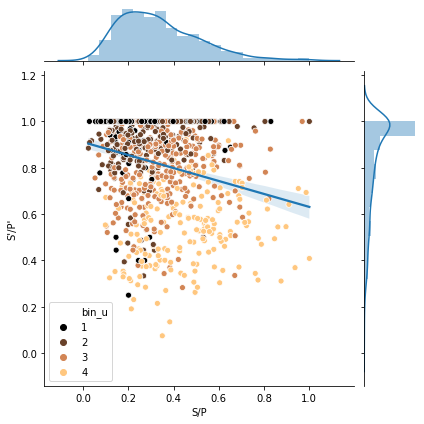

In [17]:
sns.jointplot(x, y, kind='reg', scatter=False)
ax = sns.scatterplot(x, y, hue=classes, palette="copper")
ax.set(xlabel="S/P", ylabel="S'/P'")
plt.savefig("../../results/test.pdf")

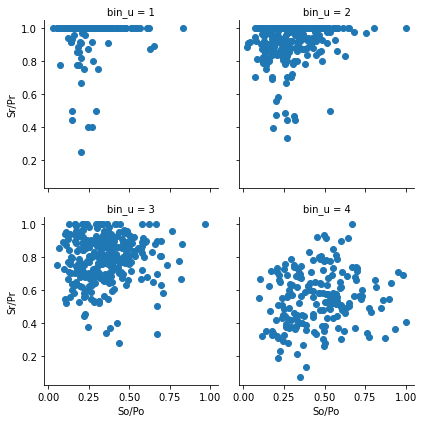

In [18]:
g = sns.FacetGrid(ratio_data, col="bin_u", col_wrap=2)
g.map(plt.scatter, "ratio_org", "ratio_rec")
g.axes[2].set_xlabel("So/Po")
g.axes[3].set_xlabel("So/Po")
g.axes[2].set_ylabel("Sr/Pr")
g.axes[0].set_ylabel("Sr/Pr")
plt.savefig("../../results/sp_ratio_ratio_ubins_distinct.pdf")

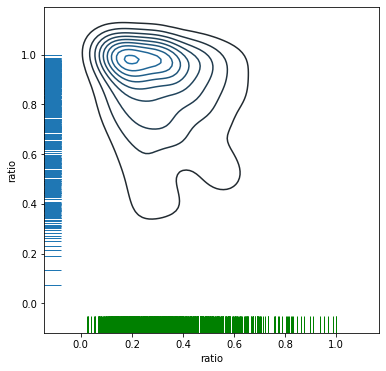

In [19]:
f, ax = plt.subplots(figsize=(6, 6))
sns.kdeplot(x, y, ax=ax)
sns.rugplot(x, color="g", ax=ax)
sns.rugplot(y, vertical=True, ax=ax);

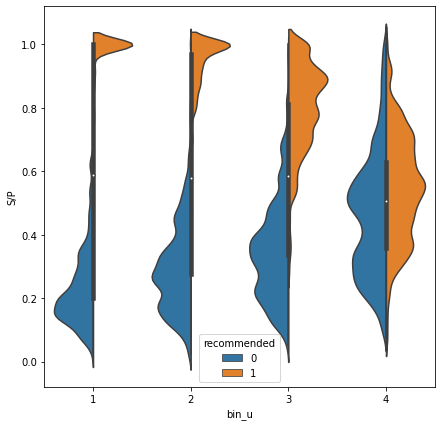

In [20]:
f, ax = plt.subplots(figsize=(7, 7))
sns.violinplot(x="u_bin_nb", y="ratio", hue="recommended", data=org_data, split=True, scale="count", bw=0.17)
ax.set(xlabel="bin_u", ylabel="S/P")
plt.savefig("../../results/sp_ratio_violin_split_binu.pdf")

In [31]:
# Getting total S/P ratio for each user
print("Computing diversity ratio...")
sp_data = get_songs_data(data, obs_threshold=0, separate_rec=False)

print("Organizing data...")
# get_songs_data produces a pd.Series, which we turn into a DataFrame before adjusting some column names
sp_data = sp_data.to_frame()
sp_data.index.names = ["user"]
sp_data.columns = ["ratio"]

sp_data = sp_data.merge(u_bins, on="user")
sp_data

Computing diversity ratio...
Organizing data...


,user,ratio,rate,u_bin_nb
0,00877d231a1d10859eefd4288ecc493fd1ea3589,0.259634,0.480815,4
1,018ca9ed6e4c4a466ff2ac0cccc00b0733e8976e,0.274580,0.208072,3
2,01d78f7619786f5f06843b5f1cb7d7b15a934731,0.273009,0.012827,1
3,0282983996af7f6b2a27cfff67fc8982619561d6,0.454339,0.186013,3
4,02eae2623eaf23461bbadd9c4f3ae1f659a90809,0.510879,0.122784,3
...,...,...,...,...
1012,fe22a3978a595c3a63cb40558db7804956f8e1d7,0.415179,0.020236,2
1013,fe8b03dc9d448192808c8cd2bf76657b7562b3ae,0.399731,0.012415,1
1014,fea927761d221701b2bf1b6acc2de6d91d060071,0.080725,0.003943,1
1015,ff7672529f1387bf35e1296f79009275287980a8,0.190534,0.006122,1


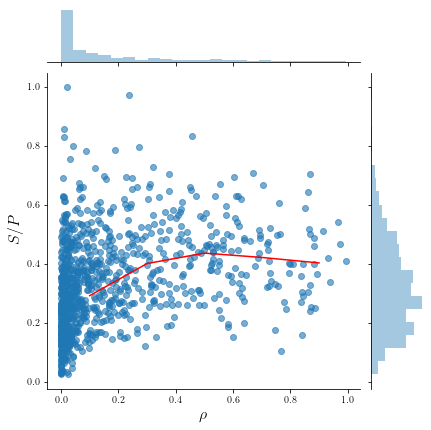

In [113]:
# f, ax = plt.subplots(figsize=(7, 7))
h = sns.jointplot(x="rate", y="ratio", data=sp_data, alpha=0.6)
sns.lineplot(x="rate", y="ratio", data=sp_means, ax=h.ax_joint, color="r", markers=True)
h.set_axis_labels(r'$\rho$', r'$S/P$', fontsize=16)
plt.savefig("../../results/sp_rho_scatter_meanbins.pdf")

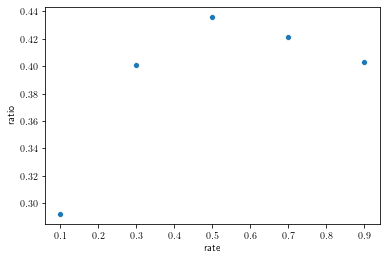

In [81]:
sp_data["quantile"] = pd.cut(sp_data["rate"], 5)
sp_means = sp_data.groupby("quantile").mean()["ratio"].to_frame().reset_index().drop("quantile", axis=1)
sp_means["rate"] = np.arange(0.1, 1.0, 0.2)
sns.scatterplot(x="rate", y="ratio", data=sp_means)